In [36]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tqdm import tqdm_notebook as tqdm

In [37]:
import gym
from gym import spaces
import gym_dynamic_set_packing
import time

In [3]:
if hasattr(tf, 'enable_eager_execution'):
    tf.enable_eager_execution()
# we do want eager execution, because that's the norm for TF2.0
# don't forget to test occasionally to see how it works in the alpha, too

In [4]:
def discounted_episode_returns(rewards, gamma=0.99):
    """
    Given a sequence of rewards, returns the sequence
    of the discounted returns (G_t) at each time step,
    with discount rate gamma (default 0.999).
    """
    # thanks to yuhao for writing this code for another project
    length = len(rewards)
    discounts = [gamma**x for x in range(length)]
    result = [np.dot(discounts[:length-i], rewards[i:]) for i in range(length)]
    return np.array(result, dtype='float32')

In [55]:
def pg_target(policy_dist, rewards, action_trajectory):
    """
    The policy gradient target loss (without baseline). Note it has to be negative,
    because TF optimizers only want to minimize. Rewards should be cumulative and discounted.
    All inputs should already be TensorFlow objects, not lists or np arrays.
    """
    return -tf.reduce_mean(policy_dist.log_prob(action_trajectory)*rewards)

In [51]:
class MLPMatchAgent:
    def __init__(self, observation_shape, gamma=0.99):
        self.action_space = spaces.Discrete(2)
        # policy network uses TFP layer at the end.
        self.policy = tf.keras.Sequential([
            layers.Dense(32, activation='relu', input_shape=observation_shape),
            layers.Dense(32, activation='relu'),
            layers.Dense(2),
            tfp.layers.OneHotCategorical(2)
        ])
        self.optimizer = tf.compat.v1.train.AdamOptimizer()
        self.gamma = gamma
        ## need to compile for non-eager mode?
    
    def act(self, observation, reward, done):
        "Act on a single observation, return an action."
        observation_as_batch = np.expand_dims(observation, 0)
        action_sample = self.policy(observation_as_batch).sample()
        return action_sample[0].numpy()
    
    def learn(self, history_dict):
        "Perform the policy gradient update with its optimizer and policy."
        with tf.GradientTape() as tape:
            policy_dists = self.policy(tf.constant(history_dict['observations']))
            loss = pg_target(policy_dists,
                             tf.constant(discounted_episode_returns(history_dict['rewards'], gamma=self.gamma)),
                             tf.constant(history_dict['actions']))
        gradients = tape.gradient(loss, self.policy.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.policy.trainable_variables))

In [52]:
def train_loop(env, agent, episode_count, max_steps, quiet=False):
    reward = 0.0
    done = False
    ep_rewards = []
    for i in tqdm(range(episode_count)):
        if not quiet:
            print('episode {}'.format(i))
        ob = env.reset()
        total_reward = 0.0
        history_dict = {
            'actions': [],
            'observations': [],
            'rewards': []
        }
        for i in range(max_steps):
            history_dict['observations'].append(ob)
            action_onehot = agent.act(ob, reward, done)
            history_dict['actions'].append(action_onehot) # save the onehot version for logprob later
            action = np.argmax(action_onehot)
            ob, reward, done, _ = env.step(action)
            history_dict['rewards'].append(reward)
            total_reward += reward
            if not quiet:
                print('action taken: {}, reward: {}, new state: {}'.format(action, reward, env.render()))
        agent.learn(history_dict)
        if not quiet:
            print('total episode reward: {}'.format(total_reward))
        ep_rewards.append(total_reward)
    return ep_rewards

## mlp example (not sure if training totally correct)

In [39]:
env_example = gym.make('DynamicSetPacking-silly-v0')
ag = MLPMatchAgent(env_example.observation_space.shape, gamma=0.999)
ep_rewards = train_loop(env_example, ag, 10, 10, quiet=True)

## blood types example

In [53]:
env_example = gym.make('DynamicSetPacking-gurobitest-v0')
ag = MLPMatchAgent(env_example.observation_space.shape, gamma=0.999)
ep_rewards = train_loop(env_example, ag, 100, 20, quiet=True)

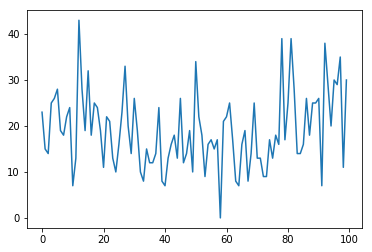

In [54]:
plt.plot(ep_rewards)

compare to random agent

In [43]:
class RandomMatchAgent:
    "A simple agent for the 0/1 problem that always matches."
    def __init__(self, match_prob):
        self.policy_dist = tfd.OneHotCategorical(probs=[1.0-match_prob, match_prob])
        self.action_space = spaces.Discrete(2)

    def act(self, observation, reward, done):
        action_sample = self.policy_dist.sample()
        return action_sample.numpy()
    
    def learn(self, history_dict):
        pass

In [48]:
env_example = gym.make('DynamicSetPacking-gurobitest-v0')
ag = RandomMatchAgent(0.5)
random_ep_rewards = train_loop(env_example, ag, 100, 50, quiet=True)

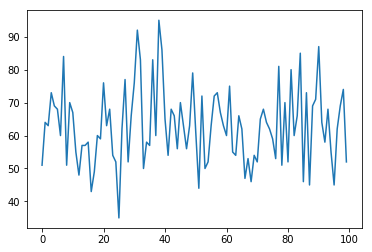

In [49]:
plt.plot(random_ep_rewards)

## old loops

In [ ]:
def train_silly_env(agent, episode_count, max_steps):
    env = gym.make('DynamicSetPacking-silly-v0')
    reward = 0.0
    done = False
    for i in range(episode_count):
        print('episode {}'.format(i))
        ob = env.reset()
        total_reward = 0.0
        history_dict = {
            'actions': [],
            'observations': [],
            'rewards': []
        }
        for i in range(max_steps):
            history_dict['observations'].append(ob)
            
            action_onehot = agent.act(ob, reward, done)
            history_dict['actions'].append(action_onehot) # save the onehot version for logprob later
            action = np.argmax(action_onehot)
            ob, reward, done, _ = env.step(action)
            history_dict['rewards'].append(reward)
            total_reward += reward
            print('action taken: {}, reward: {}, new state: {}'.format(action, reward, env.render()))
        agent.learn(history_dict)
        print('total episode reward: {}'.format(total_reward))
def test_silly_env(agent, episode_count, max_steps):
    env = gym.make('DynamicSetPacking-silly-v0')
    reward = 0.0
    done = False
    for i in range(episode_count):
        print('episode {}'.format(i))
        ob = env.reset()
        total_reward = 0.0
        history_dict = {
            'actions': [],
            'observations': [],
            'rewards': []
        }
        for i in range(max_steps):
            history_dict['observations'].append(ob)
            
            action_onehot = agent.act(ob, reward, done)
            history_dict['actions'].append(action_onehot) # save the onehot version for logprob later
            action = np.argmax(action_onehot)
            ob, reward, done, _ = env.step(action)
            history_dict['rewards'].append(reward)
            total_reward += reward
            print('action taken: {}, reward: {}, new state: {}'.format(action, reward, env.render()))
        print('total episode reward: {}'.format(total_reward))

## old pg update func, saved

In [ ]:
def pg_update(history_dict, policy_model, optim):
    """Attempt at making a policy gradient update. Seems to be working.
    
    policy_model should output a TFP dist so we can get the log_prob.
    optim is any TensorFlow optimizer (Adam tends to work)
    history_dict should contain 'observations', 'rewards', and 'actions' from a rollout.
    """
    # policy_model outputs a TFP distribution
    # here, starting to define policy gradient operations. use gradient tape
    with tf.GradientTape() as tape:
        policy_dists = policy_model(tf.constant(history_dict['observations']))
        loss = pg_target(policy_dists, tf.constant(history_dict['rewards']), tf.constant(history_dict['actions']))
    gradients = tape.gradient(loss, policy_model.trainable_variables)
    optim.apply_gradients(zip(gradients, policy_model.trainable_variables))

## random agent example

In [ ]:
class RandomMatchAgent:
    "A simple agent for the 0/1 problem that always matches."
    def __init__(self, match_prob):
        self.policy_dist = tfd.OneHotCategorical(probs=[1.0-match_prob, match_prob])
        self.action_space = spaces.Discrete(2)

    def act(self, observation, reward, done):
        action_sample = self.policy_dist.sample()
        return action_sample.numpy()

In [ ]:
test_silly_env(RandomMatchAgent(0.3), 1, 10)

## notes below

# General pattern for deep RL algorithms

OpenAI has a "Model" class that creates two policy networks, the "act_model" and the "train_model".

The "act_model" has a "step" function (note model.step = model.act_model.step at some point) which takes one step at a time. This is run in the usual way, in a Python loop, to collect one or more trajectories. These trajectories are used as inputs to the train_model to make an update.

The act_model and the train_model share weights. In other words there is a core "policy" network, shared between both of them. It's just that in the act_model, it gets applied to single states, and there are never any gradients, while in the train_model, it gets applied to batches and there are losses.


# Example of using Keras models, with TFP layer at the end (this is a nice way to represent a policy)

One could also have just the Keras model, and manually create TFP distribution objects taking them in. But why not do things this way instead? It makes it really simple.

In effect, calling the Module ends up spitting out an object from which you can sample, or get the log_prob.

For this categorical case, passing in a batch of 1 will give you a single sample of size 1xactions. Passing in a batch of n gives you a sample of size n by actions. In both cases this is parameterized by the inputs correctly. You can also call sample(n) to get many of these (iid from the distribution).

In [ ]:
def create_policy_mlp(action_dim, observation_dim):
    return tf.keras.Sequential([
        layers.Dense(32, activation='relu', input_shape=(observation_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(action_dim),
        tfp.layers.OneHotCategorical(action_dim)
    ])

In [ ]:
test = create_policy_mlp(2, 5)

In [ ]:
act_input = tf.constant([[1.0,2.0,3.0,4.0,5.0]])

In [ ]:
act_result=test(act_input)

In [ ]:
act_result.sample()

In [ ]:
obs_input = tf.constant([[1.0,2.0,3.0,4.0,5.0],[1.0,2.0,1.0,4.0,5.0],[1.0,2.0,1.0,4.0,5.0]])

In [ ]:
obs_dist = test(obs_input)